<a href="https://colab.research.google.com/github/KendallScott/ML2/blob/main/Scott_Kendall_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2

This is called DeathToGridSearch because with this example you will never have to think about how to manage a large number of classifiers etc simultaneously.  You will now be able to run and collect results in a very straightforward manner.  #LongLongLiveGridSearch!

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

from itertools import product
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

import itertools
from itertools import *
from numpy import arange
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
from xgboost import XGBClassifier

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset?resource=download

df = pd.read_csv('/content/drive/MyDrive/Employee.csv', encoding = 'ISO-8859-1',low_memory=False)

Mounted at /content/drive


In [14]:
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [76]:
X = df.loc[:,df.columns != 'LeaveOrNot']
y = df['LeaveOrNot'].values.flatten()

In [77]:
df_num = X.select_dtypes(exclude='object')
num_cols = df_num.columns

# impute numeric with median
for i in num_cols:
    df_num[i] = df_num[i].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))
df_num.info()

df_cat = X.select_dtypes(include='object')
cat_cols = df_cat.columns

# scale numerical data
scaler = StandardScaler()
df_num = scaler.fit_transform(df_num)

#one hot encode cat data
encoder = OneHotEncoder(sparse_output=False)
df_cat = encoder.fit_transform(df_cat)
X = np.hstack([df_num,df_cat])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   JoiningYear                4653 non-null   int64
 1   PaymentTier                4653 non-null   int64
 2   Age                        4653 non-null   int64
 3   ExperienceInCurrentDomain  4653 non-null   int64
dtypes: int64(4)
memory usage: 145.5 KB


In [17]:
education = df[['Education', 'LeaveOrNot','City']].groupby(['Education', 'LeaveOrNot']).count().reset_index()
education

,Education,LeaveOrNot,City
0,Bachelors,0,2472
1,Bachelors,1,1129
2,Masters,0,447
3,Masters,1,426
4,PHD,0,134
5,PHD,1,45


### Dictionary functions

In [18]:
import re
#reference: https://stackoverflow.com/questions/69300562/how-to-define-the-grid-for-using-grid-search-from-scratch-in-python

#create the dictionary used to iterate and run grid search
def makeGrid(pars_dict):
    keys=pars_dict.keys()
    length = len(keys)
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds


### Grid Search Function

In [74]:
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X,y)

def search_results(model_type, model, grid, results):
  grid=grid
  model_type=model_type
  parameters = {}
  param_dict = {}

  for x, i in enumerate(grid):
            model.set_params(**i)
            model.fit(X,y)
            score = cross_val_score(model, X, y, scoring='accuracy', cv=5)
            score=score.mean()
            results =np.append(results, np.ravel(score))
            if max(results)==score:
              #print('best model & params: ', i)
              best_model = i
              best_score = score

            #updating dictionary with results

            param_dict.update(i)
            iteration = x
            param_dict.update(param_dict)
            param_dict["results"] = score
            param_dict["model"] = model_type
            param_dict["iteration"] = iteration

            keys=param_dict.keys()
            new_dict = {}

            #updating columns to be unique for each iteration, to prevent replacing values
            for x, i in enumerate(keys):
                key =i + str(iteration)
                new_dict[key]=param_dict[i]

                parameters.update(new_dict)

                #new_dict[key] = param_dict[i]
  print('best model: ', best_model, ' best score: ', best_score)
  return parameters

### Running the custom grid search and dictionary functions

In [26]:
def grid_search(model_version):
  param_res_clean = {}
  model_version = model_version
  model_selection = ['Logistic Regression', 'Random Forest', 'Linear SVC', 'XGBoost']
  #creating different params for different models in loop
  model_selection_results = {}
  grid_parameters = {}
  grid_results = np.empty(0)

  if model_version=='Logistic Regression':
    model=LogisticRegression(random_state=45,penalty='elasticnet',class_weight='balanced',solver='saga')
    l1 = arange(0, 1, 0.1)
    C = [  0.001,  0.1,  0.5, 1]
    max_iter = [25,  50, 60, 75, 100]

    hyper_dict = {'C': C, 'l1_ratio': l1, 'max_iter':max_iter}
    grid = makeGrid(hyper_dict)
    param = {}
    param_res =search_results(model_version, model, grid, grid_results)
    hyper_dict["iteration"] = ''
    hyper_dict["results"] =''

    param_res = {}
    param_res =search_results(model_version, model, grid, grid_results)
    return param_res

  elif model_version=='Random Forest':
    model = RandomForestClassifier(criterion='gini',class_weight='balanced')
    n_estimators = [50, 100, 200]
    max_features = ['sqrt','log2',20]

    hyper_dict = {'n_estimators': n_estimators, 'max_features': max_features}
    grid = makeGrid(hyper_dict)
    param_res = {}
    param_res =search_results(model_version, model, grid, grid_results)
    hyper_dict["iteration"] = ''
    hyper_dict["results"] =''

    param_res = {}
    param_res =search_results(model_version, model, grid, grid_results)
    return param_res

  elif model_version=='Linear SVC':
    model = LinearSVC(max_iter=100000,tol=0.01,dual=True,class_weight = 'balanced')
    C = [.001,.005,.01,.05,.1,.2,.5,.8,1,3,5,20,50]

    hyper_dict = {'C': C}
    grid = makeGrid(hyper_dict)
    hyper_dict["iteration"] = ''
    hyper_dict["results"] =''

    param_res = {}
    param_res =search_results(model_version, model, grid, grid_results)
    return param_res

In [27]:
def dict_cleanup(results_dict):
  key_list = list(results_dict.keys())
  key_list_new = np.empty(0)
  for x in key_list:
      new_val = (re.sub('[^a-zA-Z_]', '', x))
      new_val=str(new_val)
      key_list_new = np.append(key_list_new, new_val)
  key_list_new = np.unique(key_list_new)

  new_data = {}
  for x,i in enumerate(key_list_new):
          new_column = str(i)
          def slicedict(d, s):
              return {k:v for k,v in d.items() if k.startswith(new_column)}
          param_dict_copy = slicedict(results_dict, i)
          new_data_values = list(param_dict_copy.values())
          new_data_empty ={}
          new_data_empty[new_column] = new_data_values
          new_data.update(new_data_empty)
  return new_data

In [28]:
Linear_SVC = grid_search('Linear SVC')
Linear_SVC_clean = dict_cleanup(Linear_SVC)
Linear_SVC_clean

best model:  {'C': 0.05}  best score:  0.6916027395678135


{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 3, 5, 20, 50],
 'iteration': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'model': ['Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC',
  'Linear SVC'],
 'results': [0.6881641892750308,
  0.6888077336197637,
  0.6885947587863669,
  0.6916027395678135,
  0.691172863033159,
  0.6903133409560769,
  0.690313340956077,
  0.690313340956077,
  0.690313340956077,
  0.690313340956077,
  0.690313340956077,
  0.690313340956077,
  0.690313340956077]}

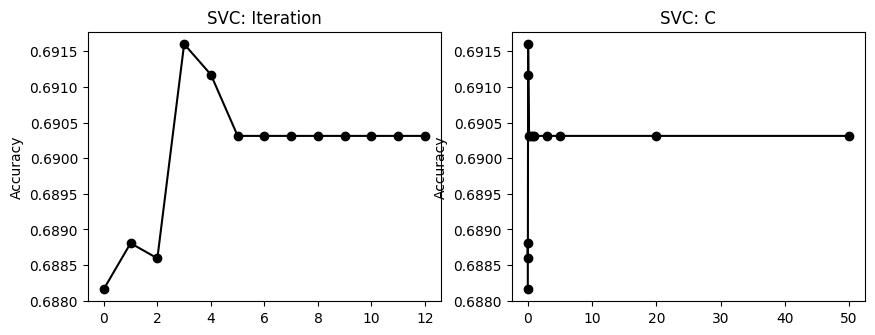

In [70]:
import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5, 3.5, forward=True)

# define data values
res = Linear_SVC_clean["iteration"]  # X-axis points
resy = Linear_SVC_clean["results"]  # Y-axis points
plt.subplot(1, 3, 1)
plt.title('SVC: Iteration')
plt.ylabel('Accuracy')


plt.plot(res, resy, 'ko-') # Plot the chart
res = Linear_SVC_clean["C"]  # X-axis points
resy = Linear_SVC_clean["results"]  # Y-axis points
plt.subplot(1, 3, 2)
plt.title('SVC: C')
plt.ylabel('Accuracy')
plt.plot(res, resy, 'ko-') # Plot the chart


plt.show()  # display

In [78]:
Logistic_Regression = grid_search('Logistic Regression')
Logistic_Regression_clean = dict_cleanup(Logistic_Regression)
Logistic_Regression_clean

best model:  {'C': 0.001, 'l1_ratio': 0.1, 'max_iter': 100}  best score:  0.7072873427809154
best model:  {'C': 0.001, 'l1_ratio': 0.1, 'max_iter': 100}  best score:  0.7072873427809154


{'C': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,

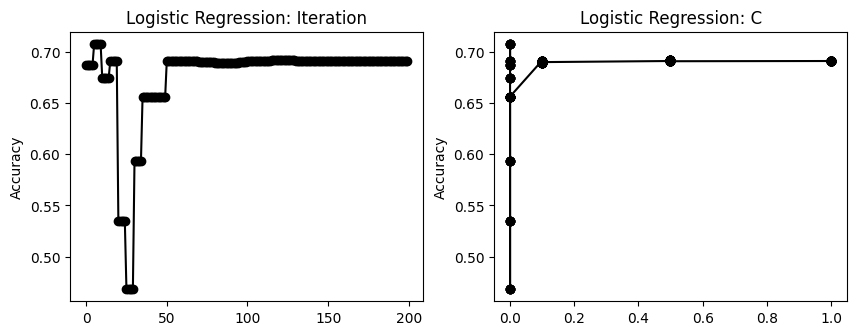

In [80]:
import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5, 3.5, forward=True)

# define data values
res = Logistic_Regression_clean["iteration"]  # X-axis points
resy = Logistic_Regression_clean["results"]  # Y-axis points
plt.subplot(1, 3, 1)
plt.title('Logistic Regression: Iteration')
plt.ylabel('Accuracy')
plt.plot(res, resy, 'ko-') # Plot the chart

res = Logistic_Regression_clean["C"]  # X-axis points
resy = Logistic_Regression_clean["results"]  # Y-axis points
plt.subplot(1, 3, 2)
plt.title('Logistic Regression: C')
plt.ylabel('Accuracy')
plt.plot(res, resy, 'ko-') # Plot the chart


plt.show()  # display

In [81]:
Random_Forest = grid_search('Random Forest')
Random_Forest_clean = dict_cleanup(Random_Forest)
Random_Forest_clean

best model:  {'n_estimators': 50, 'max_features': 'sqrt'}  best score:  0.8265613342111038
best model:  {'n_estimators': 200, 'max_features': 'log2'}  best score:  0.8246263123245903


{'iteration': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'max_features': ['sqrt', 'log2', 20, 'sqrt', 'log2', 20, 'sqrt', 'log2', 20],
 'model': ['Random Forest',
  'Random Forest',
  'Random Forest',
  'Random Forest',
  'Random Forest',
  'Random Forest',
  'Random Forest',
  'Random Forest',
  'Random Forest'],
 'n_estimators': [50, 50, 50, 100, 100, 100, 200, 200, 200],
 'results': [0.822693831352575,
  0.8196846956099927,
  0.8207622743494681,
  0.8226929073836665,
  0.8209745562061836,
  0.819039303327443,
  0.8239827679798575,
  0.8246263123245903,
  0.8216190245198248]}

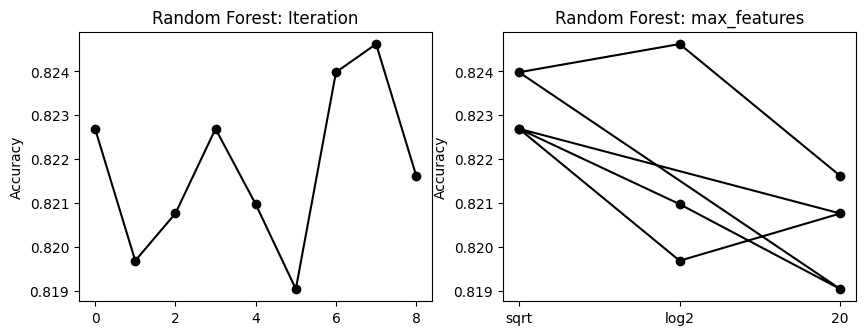

In [84]:
import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5, 3.5, forward=True)

# define data values
res = Random_Forest_clean["iteration"]  # X-axis points
resy = Random_Forest_clean["results"]  # Y-axis points
plt.subplot(1, 3, 1)
plt.title('Random Forest: Iteration')
plt.ylabel('Accuracy')
plt.plot(res, resy, 'ko-') # Plot the chart

res = Random_Forest_clean["max_features"]  # X-axis points
resy = Random_Forest_clean["results"]  # Y-axis points
plt.subplot(1, 3, 2)
plt.title('Random Forest: max_features')
plt.ylabel('Accuracy')
plt.plot(res, resy, 'ko-') # Plot the chart


plt.show()  # display

In [86]:
objective = ['binary:logistic']
eval_metric = ['error']
learning_rates = [0.1, 0.2]
max_depths = [3, 5,7, 10, 20]
gamma = [0,1,3]
lambda_ls = [1,2,3]
alpha = [0,0.1,1]

hyper_dict = {'objective': objective, 'eval_metric': eval_metric, 'eta': learning_rates, 'max_depth': max_depths, 'gamma': gamma, 'lambda': lambda_ls, 'alpha': alpha}
grid = makeGrid(hyper_dict)

for ids, (train_index, test_index) in enumerate(skf.split(X, y)):
    dtrain = xgb.DMatrix(X[train_index], label=y[train_index])
    dtest = xgb.DMatrix(X[test_index], label=y[test_index])
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    parameter_results = {}
    grid_results = np.empty(0)
    for x, i in enumerate(grid):
        print(i)
        score = xgb.cv(params=i, num_boost_round=200, dtrain=dtrain,  nfold=3, stratified=True, early_stopping_rounds=3, verbose_eval=1)
        index=score.shape[0]-1
        score=1-(score.iloc[index,2])
        print('current score: ',score)
        grid_results = np.insert(grid_results,[0], score)

        if max(grid_results)==score:
                best_result = score
                best_model = i
                print('best result:', i,' ', score)
                print('best model:', i,' ', best_result)

    #updating dictionary with results
    param_dict = {}
    param_dict.update(i)
    iteration = x
    param_dict.update(param_dict)
    param_dict["results"] = score
    param_dict["model"] = "XGBoost"
    param_dict["iteration"] = iteration

    keys=param_dict.keys()
    new_dict = {}

    for x, z in enumerate(keys):
      key =z + str(iteration)
      new_dict[key]=param_dict[z]
      parameter_results.update(new_dict)

Streaming output truncated to the last 5000 lines.
[22]	train-error:0.17054+0.00739	test-error:0.18150+0.01596
[23]	train-error:0.17054+0.00559	test-error:0.18150+0.01621
[24]	train-error:0.16651+0.00680	test-error:0.17698+0.01462
[25]	train-error:0.16618+0.00751	test-error:0.17666+0.01470
[26]	train-error:0.16377+0.00741	test-error:0.17537+0.01627
[27]	train-error:0.16328+0.00612	test-error:0.17537+0.01540
[28]	train-error:0.15893+0.00302	test-error:0.17279+0.01416
[29]	train-error:0.15780+0.00454	test-error:0.16925+0.01163
[30]	train-error:0.15796+0.00358	test-error:0.16957+0.01259
[31]	train-error:0.15651+0.00263	test-error:0.17054+0.01324
[32]	train-error:0.15619+0.00181	test-error:0.16731+0.01368
[33]	train-error:0.15506+0.00139	test-error:0.17021+0.01370
[34]	train-error:0.15522+0.00118	test-error:0.16796+0.01224
[35]	train-error:0.15458+0.00241	test-error:0.16925+0.01300
current score:  0.8326885880077369
{'objective': 'binary:logistic', 'eval_metric': 'error', 'eta': 0.2, 'max_

In [91]:
print('Best Model:', best_model, 'Accuracy:', best_result)

Best Model: {'objective': 'binary:logistic', 'eval_metric': 'error', 'eta': 0.2, 'max_depth': 7, 'gamma': 3, 'lambda': 1, 'alpha': 0.1} Accuracy: 0.8517085751128304
